In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN warnings

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Only show errors, not info/warnings
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.random import normal
from tensorflow import clip_by_value
from tqdm.keras import TqdmCallback
import numpy as np
import matplotlib.pyplot as plt

Loading the dataset and performing the preprocessing

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

noise = normal(shape=X_train.shape, mean=0.0, stddev=1.0)
X_train_noisy = X_train + noise * 0.35
X_train_noisy = clip_by_value(X_train_noisy, 0.0, 1.0)

noise_test = normal(shape=X_test.shape, mean=0.0, stddev=1.0)
X_test_noisy = X_test + noise_test * 0.35
X_test_noisy = clip_by_value(X_test_noisy, 0.0, 1.0)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Noisy training set shape: {X_train_noisy.shape}")
print(f"Noisy test set shape: {X_test_noisy.shape}")

Training set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Noisy training set shape: (60000, 28, 28, 1)
Noisy test set shape: (10000, 28, 28, 1)


In [8]:
class Conv2DAutoencoder(keras.Model):
    def __init__(self):
        super(Conv2DAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = Sequential([
            Conv2D(8, (3, 3), 
                   activation='relu', 
                   strides=2,
                   padding="same",
                   input_shape=(28, 28, 1)),
            Conv2D(4, (3, 3), 
                   activation='relu', 
                   strides=2,
                   padding="same"),
        ])
        
        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(4, (3, 3), 
                   activation='relu', 
                   strides=2,
                   padding="same",
                   input_shape=(7, 7, 4)),
            Conv2DTranspose(8, (3, 3), 
                   activation='relu', 
                   strides=2,
                   padding="same"),
            Conv2D(1, (3, 3), 
                   activation='sigmoid',
                   padding="same")  
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Conv2DAutoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

/home/stefan-stoian/FMI/Anomaly-Detection/AD/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stefan-stoian/FMI/Anomaly-Detection/AD/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/home/stefan-stoian/FMI/Anomaly-Detection/AD/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fir

In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, X_test),
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1765777282.403213   18741 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
X_train_reconstructed = autoencoder.predict(X_train)

train_reconstruction_errors = np.mean(
    np.square(X_train - X_train_reconstructed),
    axis=(1, 2, 3))

threshold = np.mean(train_reconstruction_errors) +\
    np.std(train_reconstruction_errors)
print(f"Threshold (mean + std): {threshold:.6f}")

X_test_reconstructed = autoencoder.predict(X_test)
X_test_noisy_reconstructed = autoencoder.predict(X_test_noisy)


test_reconstruction_errors = np.mean(
    np.square(X_test - X_test_reconstructed), 
    axis=(1, 2, 3))
test_noisy_reconstruction_errors = np.mean(
    np.square(X_test_noisy - X_test_noisy_reconstructed), 
    axis=(1, 2, 3))

y_test_pred = (test_reconstruction_errors > threshold).astype(int)
y_test_noisy_pred = (test_noisy_reconstruction_errors > threshold).astype(int)

y_test_true = np.zeros(len(X_test))
y_test_noisy_true = np.ones(len(X_test_noisy))

# Compute accuracy
test_accuracy = np.mean(y_test_pred == y_test_true)
test_noisy_accuracy = np.mean(y_test_noisy_pred == y_test_noisy_true)

print(f"Accuracy on original test images (expected normal): {test_accuracy:.4f}")
print(f"Accuracy on noisy test images (expected anomaly): {test_noisy_accuracy:.4f}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Threshold (mean + std): 0.003200
  1/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/stepThreshold (mean + std): 0.003200
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy on original test images (expected normal): 0.8792
Accuracy on noisy test images (expected anomaly): 1.0000
Accuracy on original test images (expected normal): 0.8792
Accuracy on noisy test images (expected anomaly): 1.0000


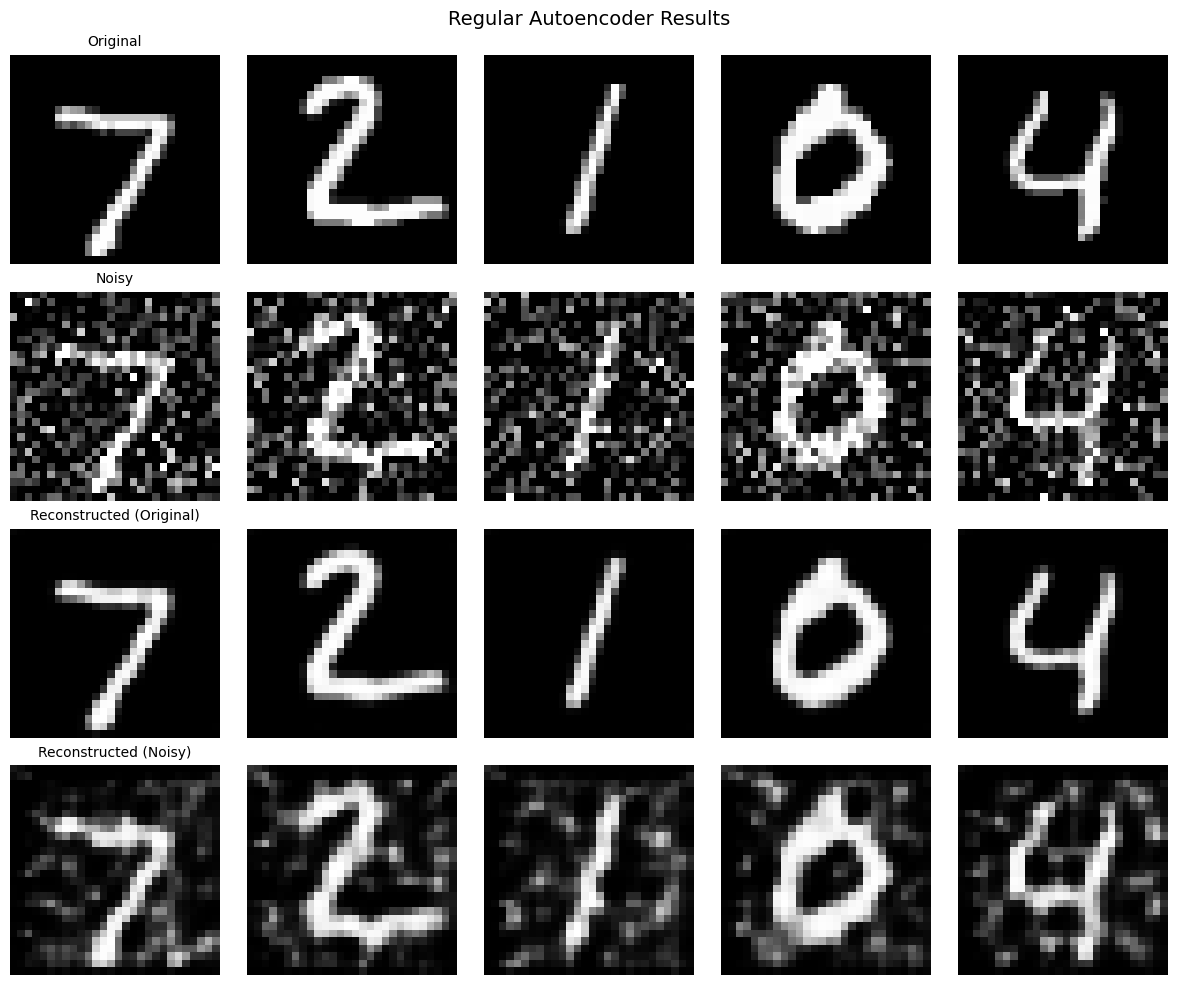

In [ ]:
n_images = 5
fig, axes = plt.subplots(4, n_images, figsize=(12, 10))

for i in range(n_images):
    # Row 1: Original test images
    axes[0, i].imshow(X_test[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10)
    
    # Row 2: Noisy test images
    axes[1, i].imshow(X_test_noisy[i].numpy().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Noisy', fontsize=10)
    
    # Row 3: Reconstructed from original
    axes[2, i].imshow(X_test_reconstructed[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('Reconstructed (Original)', fontsize=10)
    
    # Row 4: Reconstructed from noisy
    axes[3, i].imshow(X_test_noisy_reconstructed[i].squeeze(), cmap='gray')
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_title('Reconstructed (Noisy)', fontsize=10)

plt.suptitle('Regular Autoencoder Results', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
denoising_autoencoder = Conv2DAutoencoder()
denoising_autoencoder.compile(optimizer='adam', loss='mse')

history_denoising = denoising_autoencoder.fit(
    X_train_noisy, X_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_noisy, X_test),
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

/home/stefan-stoian/FMI/Anomaly-Detection/AD/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/stefan-stoian/FMI/Anomaly-Detection/AD/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


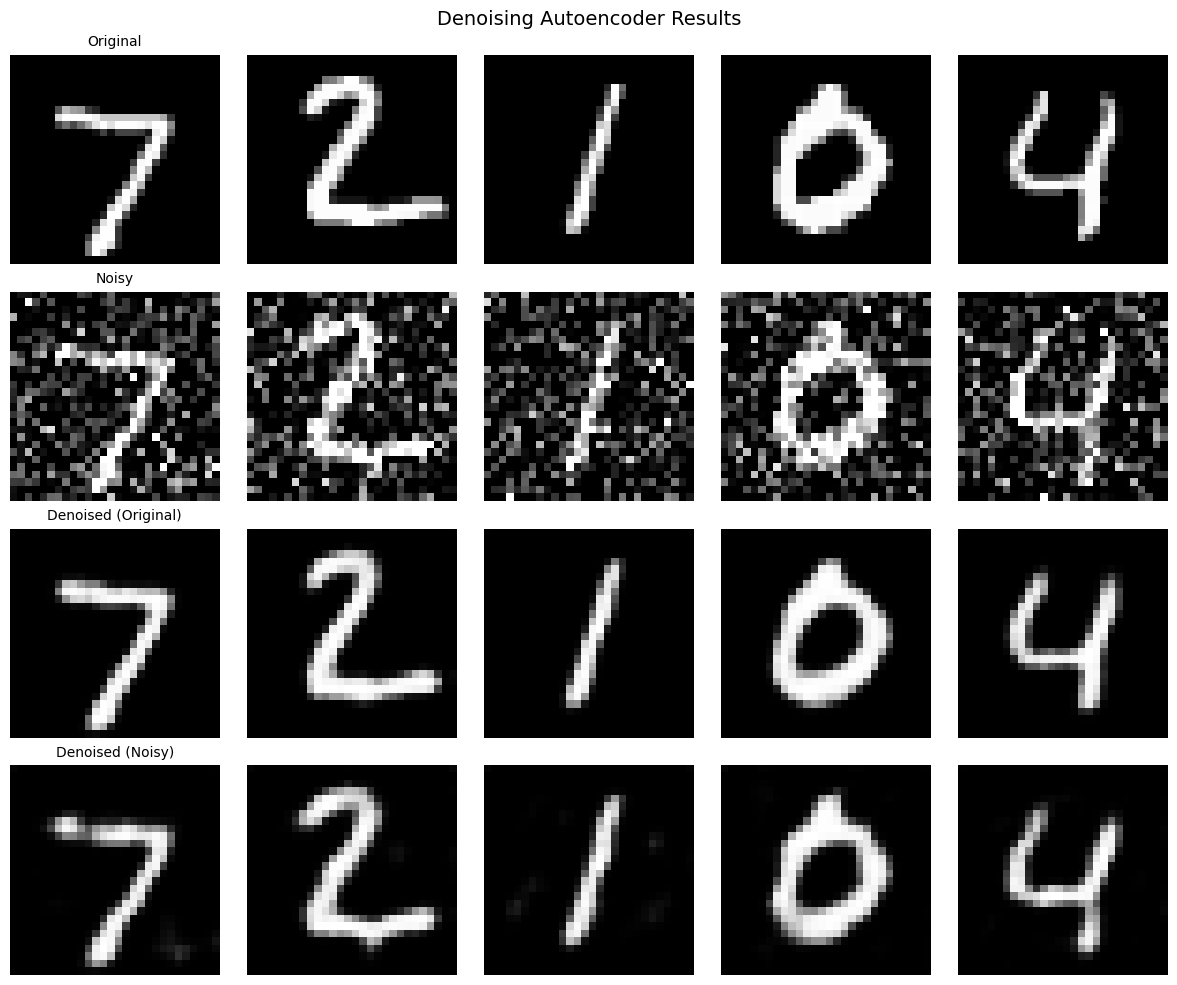

In [14]:
X_test_denoised = denoising_autoencoder.predict(X_test)
X_test_noisy_denoised = denoising_autoencoder.predict(X_test_noisy)

fig, axes = plt.subplots(4, n_images, figsize=(12, 10))
for i in range(n_images):
    # Row 1: Original test images
    axes[0, i].imshow(X_test[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10)
    
    # Row 2: Noisy test images
    axes[1, i].imshow(X_test_noisy[i].numpy().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Noisy', fontsize=10)
    
    # Row 3: Reconstructed from original
    axes[2, i].imshow(X_test_denoised[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('Denoised (Original)', fontsize=10)
    
    # Row 4: Reconstructed from noisy (denoised)
    axes[3, i].imshow(X_test_noisy_denoised[i].squeeze(), cmap='gray')
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_title('Denoised (Noisy)', fontsize=10)

plt.suptitle('Denoising Autoencoder Results', fontsize=14)
plt.tight_layout()
plt.show()